# Hands-on lab on error mitigation with Mitiq.

This notebook is a guided tutorial on error mitigation with Mitiq. The notebook is focused on the zero-noise extrapolation (ZNE) technique.


Useful links:

* Mitiq repository: https://github.com/unitaryfund/mitiq
* Mitiq documentation: https://mitiq.readthedocs.io/en/stable/
* Mitiq docs on ZNE: https://mitiq.readthedocs.io/en/stable/guide/zne.html
* Mitiq white paper: https://arxiv.org/abs/2009.04417
* Unitary Fund:  https://unitary.fund

## Checking Python packages are installed correctly

This notebook was tested with **Mitiq v0.17.0** and **qiskit v0.36.2**. It probably works with other versions too. Moreover, with minor changes, it can be adapted to quantum libraries that are different from Qiskit: Cirq, Braket, PyQuil, etc..

If you need to install Mitiq and/or Qiskit, you can uncomment and run the following cells.

In [1]:
# !pip install mitiq==0.17.0

In [2]:
# !pip install qiskit==0.36.2

You can check your locally installed version of Mitiq and of the associated frontend libraries by running the next cell.

In [3]:
from mitiq import about

about()


Mitiq: A Python toolkit for implementing error mitigation on quantum computers
Authored by: Mitiq team, 2020 & later (https://github.com/unitaryfund/mitiq)

Mitiq Version:	0.18.0dev

Core Dependencies
-----------------
Cirq Version:	0.15.0
NumPy Version:	1.20.3
SciPy Version:	1.7.3

Optional Dependencies
---------------------
PyQuil Version:	3.0.1
Qiskit Version:	0.36.0
Braket Version:	1.25.2

Python Version:	3.7.7
Platform Info:	Linux (x86_64)


## Computing a quantum expectation value without error mitigation

### Define the circuit of interest

For example, we define a circuit $U$ that prepares the GHZ state for $n$ qubits.

$$ U |00...0\rangle =  \frac{|00...0\rangle + |11...1\rangle}{\sqrt{2}} $$

This can be done by manually defining a Qiskit circuit or by calling the Mitiq function `mitiq.benchmarks.generate_ghz_circuit()`.

In [4]:
from mitiq.benchmarks import generate_ghz_circuit


n_qubits = 7

circuit = generate_ghz_circuit(n_qubits=n_qubits, return_type="qiskit")
print("GHZ circuit:")
print(circuit)

GHZ circuit:
     ┌───┐                              
q_0: ┤ H ├──■───────────────────────────
     └───┘┌─┴─┐                         
q_1: ─────┤ X ├──■──────────────────────
          └───┘┌─┴─┐                    
q_2: ──────────┤ X ├──■─────────────────
               └───┘┌─┴─┐               
q_3: ───────────────┤ X ├──■────────────
                    └───┘┌─┴─┐          
q_4: ────────────────────┤ X ├──■───────
                         └───┘┌─┴─┐     
q_5: ─────────────────────────┤ X ├──■──
                              └───┘┌─┴─┐
q_6: ──────────────────────────────┤ X ├
                                   └───┘


Let us define the Hermitian observable:

$$ A = |00...0\rangle\langle 00...0| +  |11...1\rangle\langle 11...1|.$$

In the **absence of noise**, the expectation value of $A$ is equal to 1:  

$${\rm tr}(\rho_{\rm} A)= \langle 00...0| U^\dagger A U |00...0\rangle= \frac{1}{2} + \frac{1}{2}=1.$$

In practice this means that, when measuring the state in the computational basis, we can only obtain either the bitstring  $00\dots 0$ or the biststring $11\dots 1$.

In the **presence of noise** instead, the expectation value of the same observable $A$ will be smaller.
Let's verify this fact, before applying any error mitigation.

### Run the circuit with a noiseless backend and with a noisy backend.

**Hint:** You can follow [this Qiskit example](https://qiskit.org/documentation/tutorials/simulators/2_device_noise_simulation.html) in which a (simulated) noiseless backend and a (simulated) noisy backend are compared.

In [5]:
from qiskit import QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
from qiskit import transpile
from qiskit.test import mock  # Fake (simulated) QPUs

# Number of measurements
shots = 10 ** 5

We first execute the circuit on an ideal noiseless simulator.

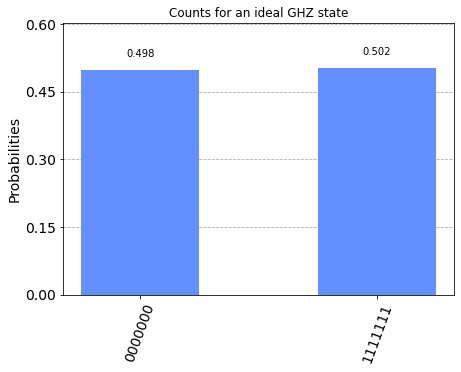

In [6]:
ideal_backend = AerSimulator()

# Append measurement gates
circuit_to_run = circuit.copy()
circuit_to_run.measure_all()

ideal_result = ideal_backend.run(circuit_to_run, shots=shots).result()
ideal_counts = ideal_result.get_counts(circuit_to_run)
plot_histogram(ideal_counts, title='Counts for an ideal GHZ state')

We now execute the same circuit on a noisy backend (a classical emulator of a real QPU)

In [7]:
noisy_backend = mock.FakeJakarta() # QPU emulator

# Compile the circuit into the native gates of the backend
compiled_circuit = transpile(circuit_to_run, noisy_backend)

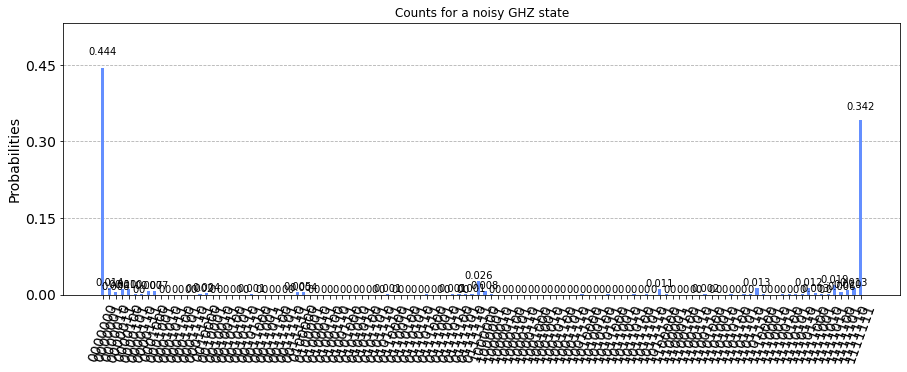

In [8]:
# Run the simulation on the noisy backend
noisy_result = noisy_backend.run(compiled_circuit, shots=shots).result()
noisy_counts = noisy_result.get_counts(compiled_circuit)
plot_histogram(noisy_counts, title='Counts for a noisy GHZ state', figsize=(15, 5))

In [9]:
ideal_expectation_value = (ideal_counts[n_qubits * "0"] + ideal_counts[n_qubits * "1"]) / shots
print(f"The ideal expectation value is <A> = {ideal_expectation_value}")

noisy_expectation_value = (noisy_counts[n_qubits * "0"] + noisy_counts[n_qubits * "1"]) / shots
print(f"The noisy expectation value is <A> = {noisy_expectation_value}")

The ideal expectation value is <A> = 1.0
The noisy expectation value is <A> = 0.7858


## Apply zero-noise extrapolation with Mitiq

Before using Mitiq we need wrap the previous code into a function that takes as input a circuit and returns the noisy expectation value of the observable $A$. This function will be used by Mitiq as a black box during the error mitigation process.

In [10]:
def execute(compiled_circuit):
    """Executes the input circuits and returns the expectation value of A=|00..0><00..0| + |11..1><11..1|."""
    print("Executing a circuit of depth:", compiled_circuit.depth())
    noisy_backend = mock.FakeJakarta()
    noisy_result = noisy_backend.run(compiled_circuit, shots=shots).result()
    noisy_counts = noisy_result.get_counts(compiled_circuit)
    noisy_expectation_value = (noisy_counts[n_qubits * "0"] + noisy_counts[n_qubits * "1"]) / shots
    return noisy_expectation_value

Let us check if the function works as expeted.

In [11]:
print(f"The noisy expectation value is <A> = {execute(compiled_circuit)}")

Executing a circuit of depth: 22
The noisy expectation value is <A> = 0.78619


We can now apply zero-noise extrapolation with Mitiq. Without advanced options, this requires a single line of code.

In [12]:
from mitiq import zne

zne_value = zne.execute_with_zne(compiled_circuit, executor=execute)
print(f"The error mitigated expectation value is <A> = {zne_value}")

Executing a circuit of depth: 22
Executing a circuit of depth: 42
Executing a circuit of depth: 64
The error mitigated expectation value is <A> = 0.7995899999999995


**Note:** As you can see from the printed output, Mitiq calls the execute function multiple times (3 in this case) to evaluate circuits of different depths in order to extrapolate the ideal result.

Let us compare the absolute estimation error obtained with and without Mitiq.

In [13]:
print(f"Error without Mitiq: {abs(ideal_expectation_value - noisy_expectation_value)}")
print(f"Error with Mitiq: {abs(ideal_expectation_value - zne_value)}")

Error without Mitiq: 0.21419999999999995
Error with Mitiq: 0.20041000000000053


## Explicitly selecting the noise-scaling method and the extrapolation method

Executing a circuit of depth: 22
Executing a circuit of depth: 42
Executing a circuit of depth: 64
The error mitigated expectation value is <A> = 0.8715399999999992


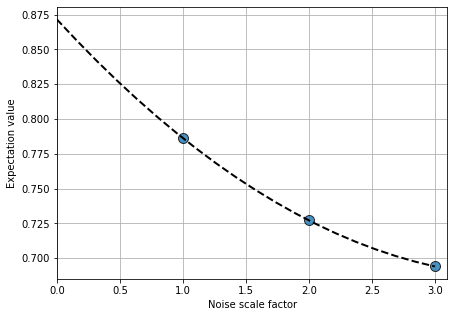

In [14]:
from mitiq import zne

# Select a noise scaling method
folding_function = zne.scaling.fold_global

# Select an inference method
factory = zne.inference.RichardsonFactory(scale_factors = [1.0, 2.0, 3.0])

zne_value = zne.execute_with_zne(
    compiled_circuit, 
    executor=execute,
    scale_noise = folding_function,
    factory = factory,
)
factory.plot_fit()
print(f"The error mitigated expectation value is <A> = {zne_value}")

## What happens behind the scenes? A low-level application of ZNE.

### STEP 1: Noise-scaled expectation values are evaluated via gate-level "unitary folding" transformations

In Mitiq one can indirectly amplify noise by intentionally increasing the depth of the circuit in different ways.

For example, the function `zne.scaling.fold_gates_at_random()` applies transformation $G \rightarrow G G^\dagger G$ to each gate of the circuit (or to a random subset of gates).

In [15]:
locally_folded_circuit = zne.scaling.fold_gates_at_random(circuit, scale_factor=3)

print("Locally folded GHZ circuit:")
print(locally_folded_circuit)

Locally folded GHZ circuit:
     ┌───┐┌───┐┌───┐                                                       »
q_0: ┤ H ├┤ H ├┤ H ├──■────■────■──────────────────────────────────────────»
     └───┘└───┘└───┘┌─┴─┐┌─┴─┐┌─┴─┐                                        »
q_1: ───────────────┤ X ├┤ X ├┤ X ├──■────■────■───────────────────────────»
                    └───┘└───┘└───┘┌─┴─┐┌─┴─┐┌─┴─┐                         »
q_2: ──────────────────────────────┤ X ├┤ X ├┤ X ├──■────■────■────────────»
                                   └───┘└───┘└───┘┌─┴─┐┌─┴─┐┌─┴─┐          »
q_3: ─────────────────────────────────────────────┤ X ├┤ X ├┤ X ├──■────■──»
                                                  └───┘└───┘└───┘┌─┴─┐┌─┴─┐»
q_4: ────────────────────────────────────────────────────────────┤ X ├┤ X ├»
                                                                 └───┘└───┘»
q_5: ──────────────────────────────────────────────────────────────────────»
                                                

**Note:** To get a simple visualization, we did't apply the preliminary circuit transpilation that we used in the previous section.

Alternatively, the function `zne.scaling.fold_global()` applies the transformation $U \rightarrow U U^\dagger U$ to the full circuit.

In [16]:
globally_folded_circuit = zne.scaling.fold_global(circuit, scale_factor=3)
print("Globally folded GHZ circuit:")
print(globally_folded_circuit)

Globally folded GHZ circuit:
     ┌───┐                                                            ┌───┐»
q_0: ┤ H ├──■──────────────────────────────────────────────────────■──┤ H ├»
     └───┘┌─┴─┐                                                  ┌─┴─┐└───┘»
q_1: ─────┤ X ├──■────────────────────────────────────────────■──┤ X ├─────»
          └───┘┌─┴─┐                                        ┌─┴─┐└───┘     »
q_2: ──────────┤ X ├──■──────────────────────────────────■──┤ X ├──────────»
               └───┘┌─┴─┐                              ┌─┴─┐└───┘          »
q_3: ───────────────┤ X ├──■────────────────────────■──┤ X ├───────────────»
                    └───┘┌─┴─┐                    ┌─┴─┐└───┘               »
q_4: ────────────────────┤ X ├──■──────────────■──┤ X ├────────────────────»
                         └───┘┌─┴─┐          ┌─┴─┐└───┘                    »
q_5: ─────────────────────────┤ X ├──■────■──┤ X ├─────────────────────────»
                              └───┘┌─┴─┐┌─┴─┐└─

In both cases, the results are longer circuits which are more sensitive to noise. Those circuits can be used to evaluate noise scaled expectation values.

For example, let's use global folding to evaluate a list of noise scaled expectation values.

In [17]:
scale_factors = [1.0, 2.0, 3.0]
# It is usually better apply unitary folding to the compiled circuit
noise_scaled_circuits = [zne.scaling.fold_global(compiled_circuit, s) for s in scale_factors]

# We run all the noise scaled circuits on the noisy backend
noise_scaled_vals = [execute(c) for c in noise_scaled_circuits]

print("Noise-scaled expectation values:", noise_scaled_vals)

Executing a circuit of depth: 22
Executing a circuit of depth: 42
Executing a circuit of depth: 64
Noise-scaled expectation values: [0.7845, 0.72802, 0.69303]


### STEP 2: Inference of the ideal result via zero-noise extrapolation


Given the list of noise scaled expectation values, one can extrapolate the zero-noise limit. This is the final classical post-processing step.

The Richardson zero-noise extrapolation is: 0.8624699999999998


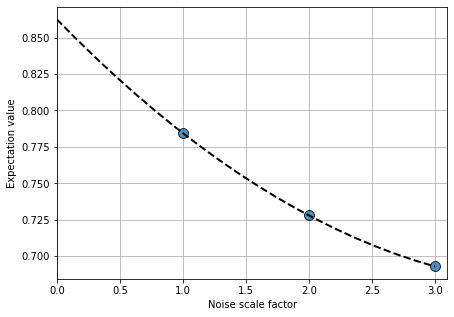

In [18]:
# Initialize a Richardson extrapolation object
richardson_factory = zne.RichardsonFactory(scale_factors)

# Load the previously measured data
for s, val in zip(scale_factors, noise_scaled_vals):
    richardson_factory.push({"scale_factor": s}, val)

print("The Richardson zero-noise extrapolation is:", richardson_factory.reduce())
_ = richardson_factory.plot_fit()

The linear zero-noise extrapolation is 0.8266533333333337


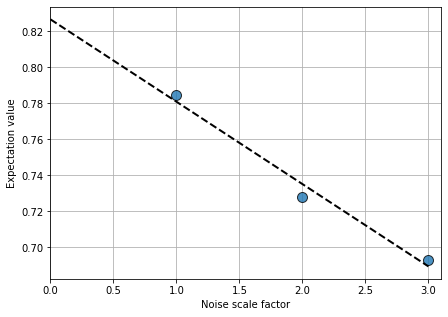

In [19]:
# Initialize a linear extrapolation object
linear_factory = zne.LinearFactory(scale_factors)

# Load the previously measured data
for s, val in zip(scale_factors, noise_scaled_vals):
    linear_factory.push({"scale_factor": s}, val)

print("The linear zero-noise extrapolation is", linear_factory.reduce())
_ = linear_factory.plot_fit()

**Note:** We evaluated two different extrapolations without measuring the system twice. This is possible since the final extrapolation step is simply a classical post-processing of the same measured data.

## References

1. _Mitiq: A software package for error mitigation on noisy quantum computers_, R. LaRose at al., [arXiv:2009.04417](https://arxiv.org/abs/2009.04417) (2020).

2. _Efficient variational quantum simulator incorporating active error minimisation_, Y. Li, S. C. Benjamin, [arXiv:1611.09301](https://arxiv.org/abs/1611.09301) (2016).

3. _Error mitigation for short-depth quantum circuits_, K. Temme, S. Bravyi, J. M. Gambetta, [arXiv:1612.02058](https://arxiv.org/abs/1612.02058) (2016).

4. _Digital zero noise extrapolation for quantum error mitigation_, 
T. Giurgica-Tiron, Y. Hindy, R. LaRose, A. Mari, W. J. Zeng,
[arXiv:2005.10921](https://arxiv.org/abs/2005.10921) (2020).

